In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest

import pylab
from pylab import rcParams
import statsmodels.api as sm
import statistics

from scipy import stats
from scipy.stats import pearsonr
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
# Define the dataframes with the csv files
try:
    offensive_players_df = pd.read_csv('yearly_player_stats_offense.csv', na_values = 'NA')
    salaries_df = pd.read_csv('combined_data_2000-2023.csv', na_values = 'NA')
except FileNotFoundError as e:
    raise

In [3]:
# Method 1: Using rename() method
# Replace 'old_column_name' with your actual column name and 'new_column_name' with your desired name
# If you want to rename multiple columns at once:
salaries_df = salaries_df.rename(columns={
    'pos': 'position',
    'player': 'player_name'
})

# Assuming both dataframes have a common column to merge on, like 'player_id' or 'name'
# Replace 'common_column' with the actual column name that exists in both dataframes
merged_df = pd.merge(
    offensive_players_df,
    salaries_df,
    on=['position', 'player_name'] # Use this if column names are the same

)

# Display the first few rows of the merged dataframe
print(merged_df.head())

    player_id player_name position  birth_year  draft_year_x  draft_round  \
0  00-0019596   Tom Brady       QB        1977        2000.0          6.0   
1  00-0019596   Tom Brady       QB        1977        2000.0          6.0   
2  00-0019596   Tom Brady       QB        1977        2000.0          6.0   
3  00-0019596   Tom Brady       QB        1977        2000.0          6.0   
4  00-0019596   Tom Brady       QB        1977        2000.0          6.0   

   draft_pick  draft_ovr  height  weight  ...   tm      g     search_key   id  \
0        33.0      199.0    76.0   225.0  ...  NWE  335.0  Tom Brady, QB  181   
1        33.0      199.0    76.0   225.0  ...  NWE  335.0  Tom Brady, QB  181   
2        33.0      199.0    76.0   225.0  ...  NWE  335.0  Tom Brady, QB  181   
3        33.0      199.0    76.0   225.0  ...  NWE  335.0  Tom Brady, QB  181   
4        33.0      199.0    76.0   225.0  ...  NWE  335.0  Tom Brady, QB  181   

  year_signed  signing_tm       value  value_norm 

In [4]:
# Visually inspect dataframe to spot problems 
pd.set_option("display.max_columns", None)
merged_df

player_id       player_name position  birth_year  draft_year_x  \
0      00-0019596         Tom Brady       QB        1977        2000.0   
1      00-0019596         Tom Brady       QB        1977        2000.0   
2      00-0019596         Tom Brady       QB        1977        2000.0   
3      00-0019596         Tom Brady       QB        1977        2000.0   
4      00-0019596         Tom Brady       QB        1977        2000.0   
...           ...               ...      ...         ...           ...   
22905  00-0038120       Breece Hall       RB        2001        2022.0   
22906  00-0038122    Desmond Ridder       QB        1999        2022.0   
22907  00-0038124  Christian Watson       WR        1999        2022.0   
22908  00-0038128      Malik Willis       QB        1999        2022.0   
22909  00-0038129        Cade Otton       TE        1999        2022.0   

       draft_round  draft_pick  draft_ovr  height  weight             college  \
0              6.0        33.0      199.0    76.0   225.0            Michigan   
1              6.0        33.0      199.0    76.0   225.0            Michigan   
2              6.0        33.0      199.0    76.0   225.0            Michigan   
3              6.0        33.0      199.0    76.0   225.0            Michigan   
4              6.0        33.0      199.0    76.0   225.0            Michigan   
...            ...         ...        ...     ...     ...                 ...   
22905          2.0         4.0       36.0    71.0   217.0          Iowa State   
22906          3.0        10.0       74.0    76.0   215.0          Cincinnati   
22907          2.0         2.0       34.0    76.0   208.0  North Dakota State   
22908          3.0        22.0       86.0    73.0   225.0             Liberty   
22909          4.0         1.0      106.0    77.0   247.0          Washington   

       season season_type team conference division  shotgun  no_huddle  \
0        2012        POST   NE        AFC     East     73.0       27.0   
1        2012        POST   NE        AFC     East     73.0       27.0   
2        2012        POST   NE        AFC     East     73.0       27.0   
3        2012        POST   NE        AFC     East     73.0       27.0   
4        2012        POST   NE        AFC     East     73.0       27.0   
...       ...         ...  ...        ...      ...      ...        ...   
22905    2024         REG  NYJ        AFC     East    175.0       15.0   
22906    2024         REG   LV        AFC     West     81.0       19.0   
22907    2024         REG   GB        NFC    North     45.0        4.0   
22908    2024         REG   GB        NFC    North     68.0        5.0   
22909    2024         REG   TB        NFC    South     77.0       10.0   

       qb_dropback  qb_scramble  pass_attempts  complete_pass  \
0             95.0          2.0           92.0           54.0   
1             95.0          2.0           92.0           54.0   
2             95.0          2.0           92.0           54.0   
3             95.0          2.0           92.0           54.0   
4             95.0          2.0           92.0           54.0   
...            ...          ...            ...            ...   
22905         76.0          0.0            0.0            0.0   
22906         79.0          5.0           67.0           41.0   
22907         54.0          0.0            0.0            0.0   
22908         71.0          8.0           54.0           40.0   
22909         87.0          0.0            0.0            0.0   

       incomplete_pass  passing_yards  receiving_yards  yards_after_catch  \
0                 38.0          664.0              0.0              333.0   
1                 38.0          664.0              0.0              333.0   
2                 38.0          664.0              0.0              333.0   
3                 38.0          664.0              0.0              333.0   
4                 38.0          664.0              0.0              333.0   
...           

In [5]:
# Investigate datatypes, number of non-NaN values, and dataframe shape. Considered data profiling.
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22910 entries, 0 to 22909
Columns: 673 entries, player_id to gtd_norm
dtypes: float64(655), int64(7), object(11)
memory usage: 117.6+ MB


In [6]:
# 1. Check the total number of duplicates
duplicate_count = merged_df.duplicated().sum()
print(f"Total number of duplicate rows: {duplicate_count}")

# 2. View the duplicate rows
duplicate_rows = merged_df[merged_df.duplicated(keep='first')]
print("\nDuplicate rows:")
display(duplicate_rows.head())

# 3. Get a summary of duplicate counts by column
duplicate_counts_by_column = {col: merged_df.duplicated(subset=[col]).sum() for col in merged_df.columns}
print("\nDuplicate counts by individual columns:")
for col, count in duplicate_counts_by_column.items():
    if count > 0:
        print(f"{col}: {count} duplicates")

Total number of duplicate rows: 752

Duplicate rows:


player_id      player_name position  birth_year  draft_year_x  \
330  00-0025394  Adrian Peterson       RB        1985        2007.0   
508  00-0026189   DeSean Jackson       WR        1986        2008.0   
509  00-0026189   DeSean Jackson       WR        1986        2008.0   
841  00-0027902       Dez Bryant       WR        1988        2010.0   
986  00-0028042     Luke Stocker       TE        1988        2011.0   

     draft_round  draft_pick  draft_ovr  height  weight         college  \
330          1.0         7.0        7.0    73.0   220.0        Oklahoma   
508          2.0        18.0       49.0    70.0   175.0      California   
509          2.0        18.0       49.0    70.0   175.0      California   
841          1.0        24.0       24.0    74.0   220.0  Oklahoma State   
986          4.0         7.0      104.0    77.0   253.0       Tennessee   

     season season_type team conference division  shotgun  no_huddle  \
330    2012         REG  MIN        NFC    North     39.0        7.0   
508    2012         REG  PHI        NFC     East     52.0        8.0   
509    2012         REG  PHI        NFC     East     52.0        8.0   
841    2012         REG  DAL        NFC     East    104.0       12.0   
986    2012         REG   TB        NFC    South      6.0        0.0   

     qb_dropback  qb_scramble  pass_attempts  complete_pass  incomplete_pass  \
330         50.0          0.0            0.0            0.0              0.0   
508         88.0          0.0            0.0            0.0              0.0   
509         88.0          0.0            0.0            0.0              0.0   
841        138.0          0.0            0.0            0.0              0.0   
986         28.0          0.0            0.0            0.0              0.0   

     passing_yards  receiving_yards  yards_after_catch  rush_attempts  \
330            0.0            214.0              183.0          332.0   
508            0.0            700.0              228.0            3.0   
509            0.0            700.0              228.0            3.0   
841            0.0           1371.0              455.0            2.0   
986            0.0            165.0               88.0            0.0   

     rushing_yards  tackled_for_loss  first_down_pass  first_down_rush  \
330         2013.0              48.0             10.0             80.0   
508           -7.0               1.0             30.0              0.0   
509           -7.0               1.0             30.0              0.0   
841           -5.0               1.0             53.0              0.0   
986            0.0               0.0              8.0              0.0   

     third_down_converted  third_down_failed  fourth_down_converted  \
330                  10.0               18.0                    2.0   
508                   8.0               11.0                    0.0   
509                   8.0               11.0                    0.0   
841                  15.0               26.0                    1.0   
986                   0.0                2.0                    0.0   

     fourth_down_failed  rush_touchdown  pass_touchdown  safety  interception  \
330                 1.0            10.0             1.0     0.0           1.0   
508                 2.0             0.0             2.0     0.0           3.0   
509                 2.0             0.0             2.0     0.0           3.0   
841                 0.0             0.0            12.0     0.0           2.0   
986                 0.0             0.0             1.0     0.0           0.0   

     fumble  fumble_lost  fumble_forced  fumble_not_forced  \
330     4.0          2.0            4.0                0.0   
508     1.0          0.0            1.0                0.0   
509     1.0          0.0            1.0                0.0   
841     2.0          1.0            2.0                0.0   
986     0.0          0.0            0.0                0.0   

     fumble_out_of_bounds  receptions  targ


Duplicate counts by individual columns:
player_id: 22012 duplicates
player_name: 22017 duplicates
position: 22902 duplicates
birth_year: 22885 duplicates
draft_year_x: 22887 duplicates
draft_round: 22903 duplicates
draft_pick: 22864 duplicates
draft_ovr: 22661 duplicates
height: 22895 duplicates
weight: 22804 duplicates
college: 22731 duplicates
season: 22897 duplicates
season_type: 22908 duplicates
team: 22878 duplicates
conference: 22908 duplicates
division: 22906 duplicates
shotgun: 22445 duplicates
no_huddle: 22759 duplicates
qb_dropback: 22438 duplicates
qb_scramble: 22853 duplicates
pass_attempts: 22488 duplicates
complete_pass: 22583 duplicates
incomplete_pass: 22689 duplicates
passing_yards: 22199 duplicates
receiving_yards: 21869 duplicates
yards_after_catch: 21970 duplicates
rush_attempts: 22613 duplicates
rushing_yards: 22140 duplicates
tackled_for_loss: 22866 duplicates
first_down_pass: 22675 duplicates
first_down_rush: 22823 duplicates
third_down_converted: 22817 duplicat

In [7]:
# Filter merged_df for QB position only
qb_df = merged_df[merged_df['position'] == 'QB']

# Print the shape to verify the filtering
print(f"Original dataframe shape: {merged_df.shape}")
print(f"QB-only dataframe shape: {qb_df.shape}")

# Display the first few rows to verify
print("\nFirst few rows of QB-only dataframe:")
display(qb_df.head())

Original dataframe shape: (22910, 673)
QB-only dataframe shape: (4482, 673)

First few rows of QB-only dataframe:


player_id player_name position  birth_year  draft_year_x  draft_round  \
0  00-0019596   Tom Brady       QB        1977        2000.0          6.0   
1  00-0019596   Tom Brady       QB        1977        2000.0          6.0   
2  00-0019596   Tom Brady       QB        1977        2000.0          6.0   
3  00-0019596   Tom Brady       QB        1977        2000.0          6.0   
4  00-0019596   Tom Brady       QB        1977        2000.0          6.0   

   draft_pick  draft_ovr  height  weight   college  season season_type team  \
0        33.0      199.0    76.0   225.0  Michigan    2012        POST   NE   
1        33.0      199.0    76.0   225.0  Michigan    2012        POST   NE   
2        33.0      199.0    76.0   225.0  Michigan    2012        POST   NE   
3        33.0      199.0    76.0   225.0  Michigan    2012        POST   NE   
4        33.0      199.0    76.0   225.0  Michigan    2012        POST   NE   

  conference division  shotgun  no_huddle  qb_dropback  qb_scramble  \
0        AFC     East     73.0       27.0         95.0          2.0   
1        AFC     East     73.0       27.0         95.0          2.0   
2        AFC     East     73.0       27.0         95.0          2.0   
3        AFC     East     73.0       27.0         95.0          2.0   
4        AFC     East     73.0       27.0         95.0          2.0   

   pass_attempts  complete_pass  incomplete_pass  passing_yards  \
0           92.0           54.0             38.0          664.0   
1           92.0           54.0             38.0          664.0   
2           92.0           54.0             38.0          664.0   
3           92.0           54.0             38.0          664.0   
4           92.0           54.0             38.0          664.0   

   receiving_yards  yards_after_catch  rush_attempts  rushing_yards  \
0              0.0              333.0            3.0            4.0   
1              0.0              333.0            3.0            4.0   
2              0.0              333.0            3.0            4.0   
3              0.0              333.0            3.0            4.0   
4              0.0              333.0            3.0            4.0   

   tackled_for_loss  first_down_pass  first_down_rush  third_down_converted  \
0               0.0             34.0              0.0                  10.0   
1               0.0             34.0              0.0                  10.0   
2               0.0             34.0              0.0                  10.0   
3               0.0             34.0              0.0                  10.0   
4               0.0             34.0              0.0                  10.0   

   third_down_failed  fourth_down_converted  fourth_down_failed  \
0               13.0                    0.0                 1.0   
1               13.0                    0.0                 1.0   
2               13.0                    0.0                 1.0   
3               13.0                    0.0                 1.0   
4               13.0                    0.0                 1.0   

   rush_touchdown  pass_touchdown  safety  interception  fumble  fumble_lost  \
0             0.0             4.0     0.0           2.0     0.0          0.0   
1             0.0             4.0     0.0           2.0     0.0          0.0   
2             0.0             4.0     0.0           2.0     0.0          0.0   
3             0.0             4.0     0.0           2.0     0.0          0.0   
4             0.0             4.0     0.0           2.0     0.0          0.0   

   fumble_forced  fumble_not_forced  fumble_out_of_bounds  receptions  \
0            0.0                0.0                   0.0         0.0   
1            0.0                0.0                   0.0         0.0   
2            0.0                0.0                   0.0         0.0   
3            0.0                0.0                   0.0         0.0   
4            0.0                0.0                   0.0         0.0   

   targets 

In [8]:
# Filter qb_df for REG season type only - REG season contains more games played compared to postseason
qb_reg_df = qb_df[qb_df['season_type'] == 'REG']

# Print the shape to verify the filtering
print(f"QB-only dataframe shape: {qb_df.shape}")
print(f"QB + REG season type dataframe shape: {qb_reg_df.shape}")

# Display the first few rows to verify
print("\nFirst few rows of QB + REG season type dataframe:")
display(qb_reg_df.head())

QB-only dataframe shape: (4482, 673)
QB + REG season type dataframe shape: (3965, 673)

First few rows of QB + REG season type dataframe:


player_id player_name position  birth_year  draft_year_x  draft_round  \
9   00-0019596   Tom Brady       QB        1977        2000.0          6.0   
10  00-0019596   Tom Brady       QB        1977        2000.0          6.0   
11  00-0019596   Tom Brady       QB        1977        2000.0          6.0   
12  00-0019596   Tom Brady       QB        1977        2000.0          6.0   
13  00-0019596   Tom Brady       QB        1977        2000.0          6.0   

    draft_pick  draft_ovr  height  weight   college  season season_type team  \
9         33.0      199.0    76.0   225.0  Michigan    2012         REG   NE   
10        33.0      199.0    76.0   225.0  Michigan    2012         REG   NE   
11        33.0      199.0    76.0   225.0  Michigan    2012         REG   NE   
12        33.0      199.0    76.0   225.0  Michigan    2012         REG   NE   
13        33.0      199.0    76.0   225.0  Michigan    2012         REG   NE   

   conference division  shotgun  no_huddle  qb_dropback  qb_scramble  \
9         AFC     East    489.0      152.0        666.0          4.0   
10        AFC     East    489.0      152.0        666.0          4.0   
11        AFC     East    489.0      152.0        666.0          4.0   
12        AFC     East    489.0      152.0        666.0          4.0   
13        AFC     East    489.0      152.0        666.0          4.0   

    pass_attempts  complete_pass  incomplete_pass  passing_yards  \
9           629.0          401.0            228.0         4827.0   
10          629.0          401.0            228.0         4827.0   
11          629.0          401.0            228.0         4827.0   
12          629.0          401.0            228.0         4827.0   
13          629.0          401.0            228.0         4827.0   

    receiving_yards  yards_after_catch  rush_attempts  rushing_yards  \
9               0.0             2218.0           23.0           32.0   
10              0.0             2218.0           23.0           32.0   
11              0.0             2218.0           23.0           32.0   
12              0.0             2218.0           23.0           32.0   
13              0.0             2218.0           23.0           32.0   

    tackled_for_loss  first_down_pass  first_down_rush  third_down_converted  \
9                2.0            255.0             11.0                  78.0   
10               2.0            255.0             11.0                  78.0   
11               2.0            255.0             11.0                  78.0   
12               2.0            255.0             11.0                  78.0   
13               2.0            255.0             11.0                  78.0   

    third_down_failed  fourth_down_converted  fourth_down_failed  \
9                94.0                    6.0                 4.0   
10               94.0                    6.0                 4.0   
11               94.0                    6.0                 4.0   
12               94.0                    6.0                 4.0   
13               94.0                    6.0                 4.0   

    rush_touchdown  pass_touchdown  safety  interception  fumble  fumble_lost  \
9              5.0            34.0     0.0           8.0     2.0          0.0   
10             5.0            34.0     0.0           8.0     2.0          0.0   
11             5.0            34.0     0.0           8.0     2.0          0.0   
12             5.0            34.0     0.0           8.0     2.0          0.0   
13             5.0            34.0     0.0           8.0     2.0          0.0   

    fumble_forced  fumble_not_forced  fumble_out_of_bounds  receptions  \
9             1.0                1.0                   0.0         0.0   
10            1.0                1.0                   0.0         0.0   
11            1.0                1.0                   0.0         0.0   
12            1.0                1.0                   0.0         0.0   
13            1.0                

In [9]:
# Group by player_name and find the most recent season for each player
latest_seasons = qb_reg_df.groupby('player_name')['season'].max().reset_index()

# Merge this back with qb_reg_df to get only the rows with the most recent season for each player
qb_reg_latest_df = qb_reg_df.merge(
    latest_seasons, 
    on=['player_name', 'season'], 
    how='inner'
)

# Print the shape to verify the filtering
print(f"QB + REG season type dataframe shape: {qb_reg_df.shape}")
print(f"QB + REG + latest season dataframe shape: {qb_reg_latest_df.shape}")

# Display the first few rows to verify
print("\nFirst few rows of QB + REG + latest season dataframe:")
display(qb_reg_latest_df.head())

# Check how many unique players we have
unique_player_count = qb_reg_latest_df['player_name'].nunique()
print(f"\nNumber of unique QB players in their most recent regular season: {unique_player_count}")

QB + REG season type dataframe shape: (3965, 673)
QB + REG + latest season dataframe shape: (708, 673)

First few rows of QB + REG + latest season dataframe:


player_id player_name position  birth_year  draft_year_x  draft_round  \
0  00-0020608  David Carr       QB        1979        2002.0          1.0   
1  00-0020608  David Carr       QB        1979        2002.0          1.0   
2  00-0020608  David Carr       QB        1979        2002.0          1.0   
3  00-0020608  David Carr       QB        1979        2002.0          1.0   
4  00-0020608  David Carr       QB        1979        2002.0          1.0   

   draft_pick  draft_ovr  height  weight       college  season season_type  \
0         1.0        1.0    75.0   212.0  Fresno State    2012         REG   
1         1.0        1.0    75.0   212.0  Fresno State    2012         REG   
2         1.0        1.0    75.0   212.0  Fresno State    2012         REG   
3         1.0        1.0    75.0   212.0  Fresno State    2012         REG   
4         1.0        1.0    75.0   212.0  Fresno State    2012         REG   

  team conference division  shotgun  no_huddle  qb_dropback  qb_scramble  \
0  NYG        NFC     East      1.0        0.0          4.0          0.0   
1  NYG        NFC     East      1.0        0.0          4.0          0.0   
2  NYG        NFC     East      1.0        0.0          4.0          0.0   
3  NYG        NFC     East      1.0        0.0          4.0          0.0   
4  NYG        NFC     East      1.0        0.0          4.0          0.0   

   pass_attempts  complete_pass  incomplete_pass  passing_yards  \
0            3.0            2.0              1.0           19.0   
1            3.0            2.0              1.0           19.0   
2            3.0            2.0              1.0           19.0   
3            3.0            2.0              1.0           19.0   
4            3.0            2.0              1.0           19.0   

   receiving_yards  yards_after_catch  rush_attempts  rushing_yards  \
0              0.0               17.0            3.0           -3.0   
1              0.0               17.0            3.0           -3.0   
2              0.0               17.0            3.0           -3.0   
3              0.0               17.0            3.0           -3.0   
4              0.0               17.0            3.0           -3.0   

   tackled_for_loss  first_down_pass  first_down_rush  third_down_converted  \
0               0.0              1.0              0.0                   1.0   
1               0.0              1.0              0.0                   1.0   
2               0.0              1.0              0.0                   1.0   
3               0.0              1.0              0.0                   1.0   
4               0.0              1.0              0.0                   1.0   

   third_down_failed  fourth_down_converted  fourth_down_failed  \
0                2.0                    0.0                 0.0   
1                2.0                    0.0                 0.0   
2                2.0                    0.0                 0.0   
3                2.0                    0.0                 0.0   
4                2.0                    0.0                 0.0   

   rush_touchdown  pass_touchdown  safety  interception  fumble  fumble_lost  \
0             0.0             0.0     0.0           0.0     1.0          0.0   
1             0.0             0.0     0.0           0.0     1.0          0.0   
2             0.0             0.0     0.0           0.0     1.0          0.0   
3             0.0             0.0     0.0           0.0     1.0          0.0   
4             0.0             0.0     0.0           0.0     1.0          0.0   

   fumble_forced  fumble_not_forced  fumble_out_of_bounds  receptions  \
0            1.0                0.0                   0.0         0.0   
1            1.0                0.0                   0.0         0.0   
2            1.0                0.0                   0.0         0.0   
3            1.0                0.0                   0.0         0.0   
4            1.0                0.0                   0.0    


Number of unique QB players in their most recent regular season: 132


In [10]:
# Calculate average value_norm for each QB
qb_avg_value = qb_reg_latest_df.groupby('player_name')['value_norm'].mean().reset_index()
qb_avg_value = qb_avg_value.rename(columns={'value_norm': 'avg_value_norm'})

# Merge the average values back to qb_reg_latest_df
qb_reg_latest_df = qb_reg_latest_df.merge(qb_avg_value, on='player_name', how='left')

# Drop the original value_norm column
qb_reg_latest_df = qb_reg_latest_df.drop(columns=['value_norm'])

# Print the shape to verify
print(f"Updated dataframe shape: {qb_reg_latest_df.shape}")

# Display the first few rows to verify the changes
print("\nFirst few rows of updated dataframe with avg_value_norm:")
display(qb_reg_latest_df.head())

# Check for any duplicates in player_name
duplicate_count = qb_reg_latest_df.duplicated(subset=['player_name']).sum()
print(f"\nNumber of duplicate player_name entries: {duplicate_count}")

# If there are duplicates and you want only unique player entries:
if duplicate_count > 0:
    qb_reg_latest_df = qb_reg_latest_df.drop_duplicates(subset=['player_name'])
    print(f"After removing duplicates, dataframe shape: {qb_reg_latest_df.shape}")

Updated dataframe shape: (708, 673)

First few rows of updated dataframe with avg_value_norm:


player_id player_name position  birth_year  draft_year_x  draft_round  \
0  00-0020608  David Carr       QB        1979        2002.0          1.0   
1  00-0020608  David Carr       QB        1979        2002.0          1.0   
2  00-0020608  David Carr       QB        1979        2002.0          1.0   
3  00-0020608  David Carr       QB        1979        2002.0          1.0   
4  00-0020608  David Carr       QB        1979        2002.0          1.0   

   draft_pick  draft_ovr  height  weight       college  season season_type  \
0         1.0        1.0    75.0   212.0  Fresno State    2012         REG   
1         1.0        1.0    75.0   212.0  Fresno State    2012         REG   
2         1.0        1.0    75.0   212.0  Fresno State    2012         REG   
3         1.0        1.0    75.0   212.0  Fresno State    2012         REG   
4         1.0        1.0    75.0   212.0  Fresno State    2012         REG   

  team conference division  shotgun  no_huddle  qb_dropback  qb_scramble  \
0  NYG        NFC     East      1.0        0.0          4.0          0.0   
1  NYG        NFC     East      1.0        0.0          4.0          0.0   
2  NYG        NFC     East      1.0        0.0          4.0          0.0   
3  NYG        NFC     East      1.0        0.0          4.0          0.0   
4  NYG        NFC     East      1.0        0.0          4.0          0.0   

   pass_attempts  complete_pass  incomplete_pass  passing_yards  \
0            3.0            2.0              1.0           19.0   
1            3.0            2.0              1.0           19.0   
2            3.0            2.0              1.0           19.0   
3            3.0            2.0              1.0           19.0   
4            3.0            2.0              1.0           19.0   

   receiving_yards  yards_after_catch  rush_attempts  rushing_yards  \
0              0.0               17.0            3.0           -3.0   
1              0.0               17.0            3.0           -3.0   
2              0.0               17.0            3.0           -3.0   
3              0.0               17.0            3.0           -3.0   
4              0.0               17.0            3.0           -3.0   

   tackled_for_loss  first_down_pass  first_down_rush  third_down_converted  \
0               0.0              1.0              0.0                   1.0   
1               0.0              1.0              0.0                   1.0   
2               0.0              1.0              0.0                   1.0   
3               0.0              1.0              0.0                   1.0   
4               0.0              1.0              0.0                   1.0   

   third_down_failed  fourth_down_converted  fourth_down_failed  \
0                2.0                    0.0                 0.0   
1                2.0                    0.0                 0.0   
2                2.0                    0.0                 0.0   
3                2.0                    0.0                 0.0   
4                2.0                    0.0                 0.0   

   rush_touchdown  pass_touchdown  safety  interception  fumble  fumble_lost  \
0             0.0             0.0     0.0           0.0     1.0          0.0   
1             0.0             0.0     0.0           0.0     1.0          0.0   
2             0.0             0.0     0.0           0.0     1.0          0.0   
3             0.0             0.0     0.0           0.0     1.0          0.0   
4             0.0             0.0     0.0           0.0     1.0          0.0   

   fumble_forced  fumble_not_forced  fumble_out_of_bounds  receptions  \
0            1.0                0.0                   0.0         0.0   
1            1.0                0.0                   0.0         0.0   
2            1.0                0.0                   0.0         0.0   
3            1.0                0.0                   0.0         0.0   
4            1.0                0.0                   0.0    


Number of duplicate player_name entries: 576
After removing duplicates, dataframe shape: (132, 673)


In [11]:
# First, let's find the most recent year_signed for each player
latest_year_signed = qb_reg_latest_df.groupby('player_name')['year_signed'].max().reset_index()

# Merge this back with qb_reg_latest_df to get only the rows with the most recent year_signed for each player
qb_latest_contract_df = qb_reg_latest_df.merge(
    latest_year_signed, 
    on=['player_name', 'year_signed'], 
    how='inner'
)

# Print the shape to verify the filtering
print(f"Original dataframe shape: {qb_reg_latest_df.shape}")
print(f"After filtering for most recent year_signed dataframe shape: {qb_latest_contract_df.shape}")

# Display the first few rows to verify
print("\nFirst few rows of dataframe with most recent year_signed:")
display(qb_latest_contract_df.head())

# Check for any remaining duplicates in player_name
duplicate_count = qb_latest_contract_df.duplicated(subset=['player_name']).sum()
print(f"\nNumber of duplicate player_name entries: {duplicate_count}")

# If there are still duplicates and you want only one entry per player:
if duplicate_count > 0:
    # Keep the first occurrence of each player_name
    qb_latest_contract_df = qb_latest_contract_df.drop_duplicates(subset=['player_name'])
    print(f"After removing duplicates, dataframe shape: {qb_latest_contract_df.shape}")

Original dataframe shape: (132, 673)
After filtering for most recent year_signed dataframe shape: (132, 673)

First few rows of dataframe with most recent year_signed:


player_id     player_name position  birth_year  draft_year_x  draft_round  \
0  00-0020608      David Carr       QB        1979        2002.0          1.0   
1  00-0025423      Kevin Kolb       QB        1984        2007.0          2.0   
2  00-0026993    Josh Freeman       QB        1988        2009.0          1.0   
3  00-0023460  Jason Campbell       QB        1981        2005.0          1.0   
4  00-0023541      Kyle Orton       QB        1982        2005.0          4.0   

   draft_pick  draft_ovr  height  weight       college  season season_type  \
0         1.0        1.0    75.0   212.0  Fresno State    2012         REG   
1         4.0       36.0    75.0   218.0       Houston    2012         REG   
2        17.0       17.0    78.0   248.0  Kansas State    2013         REG   
3        25.0       25.0    77.0   235.0        Auburn    2014         REG   
4         5.0      106.0    76.0   228.0        Purdue    2014         REG   

  team conference division  shotgun  no_huddle  qb_dropback  qb_scramble  \
0  NYG        NFC     East      1.0        0.0          4.0          0.0   
1  ARI        NFC     West    163.0       16.0        217.0          7.0   
2  MIN        NFC    North     35.0        3.0         54.0          0.0   
3  CIN        AFC    North     20.0        2.0         21.0          1.0   
4  BUF        AFC     East    406.0       29.0        484.0          5.0   

   pass_attempts  complete_pass  incomplete_pass  passing_yards  \
0            3.0            2.0              1.0           19.0   
1          180.0          109.0             71.0         1169.0   
2           52.0           20.0             32.0          190.0   
3           19.0           11.0              8.0           74.0   
4          437.0          287.0            150.0         3018.0   

   receiving_yards  yards_after_catch  rush_attempts  rushing_yards  \
0              0.0               17.0            3.0           -3.0   
1              0.0              478.0           16.0          100.0   
2              0.0               87.0            0.0            0.0   
3              0.0               57.0            1.0            1.0   
4              0.0             1548.0           15.0           14.0   

   tackled_for_loss  first_down_pass  first_down_rush  third_down_converted  \
0               0.0              1.0              0.0                   1.0   
1               1.0             62.0              7.0                  22.0   
2               0.0             10.0              0.0                   6.0   
3               0.0              3.0              0.0                   0.0   
4               0.0            147.0              2.0                  50.0   

   third_down_failed  fourth_down_converted  fourth_down_failed  \
0                2.0                    0.0                 0.0   
1               47.0                    2.0                 3.0   
2               11.0                    0.0                 3.0   
3                4.0                    0.0                 2.0   
4               92.0                    6.0                 5.0   

   rush_touchdown  pass_touchdown  safety  interception  fumble  fumble_lost  \
0             0.0             0.0     0.0           0.0     1.0          0.0   
1             1.0             8.0     1.0           3.0     2.0          2.0   
2             0.0             0.0     0.0           1.0     0.0          0.0   
3             0.0             0.0     0.0           0.0     1.0          1.0   
4             1.0            18.0     1.0          10.0     3.0          3.0   

   fumble_forced  fumble_not_forced  fumble_out_of_bounds  receptions  \
0            1.0                0.0                   0.0         0.0   
1            2.0                0.0                   0.0         0.0   
2            0.0                0.0                   0.0         0.0   
3            1.0                0.0                   0.0         0.0   
4            3.0                0.0  


Number of duplicate player_name entries: 0


In [12]:
# Provides a summary of all the variables with missing values.
pd.set_option('display.max_rows', None)  # Show all rows
qb_latest_contract_df.isna().sum()

player_id                                             0
player_name                                           0
position                                              0
birth_year                                            0
draft_year_x                                          0
draft_round                                           0
draft_pick                                            0
draft_ovr                                             0
height                                                0
weight                                                0
college                                               0
season                                                0
season_type                                           0
team                                                  0
conference                                            0
division                                              0
shotgun                                               0
no_huddle                                       

In [13]:
# List of columns to keep
columns_to_keep = [
    'player_name', 'avg_value_norm', 'career_pass_ypg', 'career_rush_ypg', 
    'career_total_yards', 'career_total_tds',
    'career_passing_air_yards', 'career_interception', 'career_fumble', 'career_pass_touchdown',
    'career_rush_touchdown', 'career_rush_attempts', 'career_rushing_yards', 'career_passing_yards',
    'career_complete_pass', 'career_pass_attempts', 'games_played_career',
    'season_type', 'age'
]

# Select only these columns
qb_latest_contract_df = qb_latest_contract_df[columns_to_keep]

# Verify the result
print(f"DataFrame now has {qb_latest_contract_df.shape[1]} columns")
print(f"Missing columns: {set(columns_to_keep) - set(qb_latest_contract_df.columns)}")
qb_latest_contract_df.head()

DataFrame now has 19 columns
Missing columns: set()


player_name  avg_value_norm  career_pass_ypg  career_rush_ypg  \
0      David Carr        0.105429             9.50            -1.50   
1      Kevin Kolb        0.176367           194.83            16.67   
2    Josh Freeman        0.026617           226.56             7.83   
3  Jason Campbell        0.036999           130.78             7.56   
4      Kyle Orton        0.051264           233.67             1.47   

   career_total_yards  career_total_tds  career_passing_air_yards  \
0                8.00              0.00                      10.0   
1              211.50              1.50                    1446.0   
2              234.39              1.28                    6446.0   
3              138.33              0.72                    2851.0   
4              235.13              1.47                    3662.0   

   career_interception  career_fumble  career_pass_touchdown  \
0                  0.0            1.0                    0.0   
1                  3.0            2.0                    8.0   
2                 20.0           10.0                   23.0   
3                 10.0            6.0                   13.0   
4                 12.0            3.0                   21.0   

   career_rush_touchdown  career_rush_attempts  career_rushing_yards  \
0                    0.0                   3.0                  -3.0   
1                    1.0                  16.0                 100.0   
2                    0.0                  40.0                 141.0   
3                    0.0                  22.0                 136.0   
4                    1.0                  16.0                  22.0   

   career_passing_yards  career_complete_pass  career_pass_attempts  \
0                  19.0                   2.0                   3.0   
1                1169.0                 109.0                 180.0   
2                4078.0                 330.0                 617.0   
3                2354.0                 223.0                 377.0   
4                3505.0                 329.0                 496.0   

   games_played_career season_type   age  
0                    2         REG  33.0  
1                    6         REG  28.0  
2                   18         REG  25.0  
3                   18         REG  32.0  
4                   15         REG  31.0

In [14]:
# Check for missing values in each column
missing_values = qb_latest_contract_df.isna().sum()
print("Missing values per column:")
print(missing_values)

# Calculate percentage of missing values
missing_percentage = (missing_values / len(qb_latest_contract_df)) * 100
print("\nPercentage of missing values per column:")
print(missing_percentage)

# Identify columns with missing values
columns_with_missing = missing_values[missing_values > 0].index.tolist()
print("\nColumns with missing values:", columns_with_missing)

Missing values per column:
player_name                 0
avg_value_norm              0
career_pass_ypg             0
career_rush_ypg             0
career_total_yards          0
career_total_tds            0
career_passing_air_yards    0
career_interception         0
career_fumble               0
career_pass_touchdown       0
career_rush_touchdown       0
career_rush_attempts        0
career_rushing_yards        0
career_passing_yards        0
career_complete_pass        0
career_pass_attempts        0
games_played_career         0
season_type                 0
age                         0
dtype: int64

Percentage of missing values per column:
player_name                 0.0
avg_value_norm              0.0
career_pass_ypg             0.0
career_rush_ypg             0.0
career_total_yards          0.0
career_total_tds            0.0
career_passing_air_yards    0.0
career_interception         0.0
career_fumble               0.0
career_pass_touchdown       0.0
career_rush_touchdown       

In [15]:
qb_latest_contract_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   player_name               132 non-null    object 
 1   avg_value_norm            132 non-null    float64
 2   career_pass_ypg           132 non-null    float64
 3   career_rush_ypg           132 non-null    float64
 4   career_total_yards        132 non-null    float64
 5   career_total_tds          132 non-null    float64
 6   career_passing_air_yards  132 non-null    float64
 7   career_interception       132 non-null    float64
 8   career_fumble             132 non-null    float64
 9   career_pass_touchdown     132 non-null    float64
 10  career_rush_touchdown     132 non-null    float64
 11  career_rush_attempts      132 non-null    float64
 12  career_rushing_yards      132 non-null    float64
 13  career_passing_yards      132 non-null    float64
 14  career_com

In [16]:
# First, check the total number of rows in qb_latest_contract_df
num_rows = len(qb_latest_contract_df)
print(f"Total number of rows in qb_latest_contract_df: {num_rows}")

qb_latest_contract_df = qb_latest_contract_df.rename(columns={
    'career_total_yards': 'career_total_ypg',
    'career_total_tds': 'career_total_tdspg'
})

# Display all rows if the dataframe is not too large
# This temporarily overrides pandas display settings
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', None):
    print("\nAll rows in qb_latest_contract_df:")
    display(qb_latest_contract_df)  # Use display() in Jupyter notebooks for better formatting

Total number of rows in qb_latest_contract_df: 132

All rows in qb_latest_contract_df:


player_name  avg_value_norm  career_pass_ypg  career_rush_ypg  \
0            David Carr        0.105429             9.50            -1.50   
1            Kevin Kolb        0.176367           194.83            16.67   
2          Josh Freeman        0.026617           226.56             7.83   
3        Jason Campbell        0.036999           130.78             7.56   
4            Kyle Orton        0.051264           233.67             1.47   
5            Matt Flynn        0.058114            95.38             3.12   
6           Jake Locker        0.104557           177.00            23.52   
7      Christian Ponder        0.027612           174.42            16.12   
8          Ryan Lindley        0.007460           146.00             0.78   
9     Zach Mettenberger        0.017632           167.64             0.86   
10       Johnny Manziel        0.062020           128.25            12.58   
11   Charlie Whitehurst        0.022274           118.43             6.21   
12     Colin Kaepernick        0.366884           188.25            35.42   
13          Connor Cook        0.006040           150.00             0.00   
14        Cardale Jones        0.007992            96.00            -1.00   
15        Carson Palmer        0.444995           277.33             1.84   
16           Jay Cutler        0.395502           224.67            10.65   
17         Drew Stanton        0.021442           116.04             2.16   
18         Ryan Mallett        0.025247            85.72            -0.50   
19           T.J. Yates        0.008285            79.14             3.57   
20         Landry Jones        0.014028            77.06            -1.12   
21           Tom Savage        0.008026           153.85             0.62   
22          David Fales        0.004865            95.67             2.67   
23          Bryce Petty        0.019777           135.30             7.40   
24          Jake Rudock        0.002849            12.00             0.00   
25          Kevin Hogan        0.003549            88.71            25.14   
26         Paxton Lynch        0.018128           158.40            11.00   
27       Derek Anderson        0.036138            78.64             1.05   
28          Matt Cassel        0.079598           157.00             8.49   
29         Mark Sanchez        0.118792           198.32             4.61   
30         Sam Bradford        0.433280           241.63             4.40   
31          Andrew Luck        0.487646           275.24            18.49   
32       Brandon Weeden        0.022497           190.06             5.88   
33       Brock Osweiler        0.125619           157.83             5.66   
34         Cody Kessler        0.010793           130.29             8.24   
35           Chad Kelly        0.005614             0.00            -1.00   
36        DeShone Kizer        0.009271           171.17            25.44   
37        Kyle Lauletta        0.005043             0.00            -2.00   
38          Josh McCown        0.030961           204.98             9.72   
39          Eli Manning        0.658163           256.03             1.76   
40        Blake Bortles        0.038207           229.21            22.94   
41        Brett Hundley        0.004470           105.67            17.17   
42         Sean Mannion        0.005698            29.54            -1.31   
43            Luke Falk        0.006278           109.00             0.00   
44           Will Grier        0.006358           114.00            11.00   
45           Drew Brees        0.322286           298.35             1.42   
46          Matt Schaub        0.145766           191.69             0.44   
47        Philip Rivers        0.491352           271.91             2.10   
48           Alex Smith        0.317630           222.64            16.77   
49         Matt Barkley        0.008672           149.94            -0.67   
50      Garrett Gilbert        0.003716            40.50             4.17   
51      

In [17]:
# Convert 'player_name' and 'season_type' columns to categorical data type
qb_latest_contract_df['player_name'] = qb_latest_contract_df['player_name'].astype('category')
qb_latest_contract_df['season_type'] = qb_latest_contract_df['season_type'].astype('category')

# Verify the conversion
print(qb_latest_contract_df[['player_name', 'season_type']].dtypes)

player_name    category
season_type    category
dtype: object


This code will convert both columns to the categorical data type, which is more memory-efficient for columns with repeated values and also signals to pandas and other libraries that these columns represent categorical rather than continuous data.

In [18]:
# Define the age bins and labels
age_bins = [0, 25, 30, 35, 40, 100]  # Bin edges
age_labels = ['20-25', '26-30', '31-35', '36-40', '40+']  # Bin labels

# Create a new column with age groups
qb_latest_contract_df['age_group'] = pd.cut(qb_latest_contract_df['age'], 
                                           bins=age_bins, 
                                           labels=age_labels, 
                                           right=True)

# Convert to category type for better memory usage
qb_latest_contract_df['age_group'] = qb_latest_contract_df['age_group'].astype('category')

# Display the first few rows to verify
print(qb_latest_contract_df[['player_name', 'age', 'age_group']].head())

# Count the number of players in each age group
print(qb_latest_contract_df['age_group'].value_counts().sort_index())

      player_name   age age_group
0      David Carr  33.0     31-35
1      Kevin Kolb  28.0     26-30
2    Josh Freeman  25.0     20-25
3  Jason Campbell  32.0     31-35
4      Kyle Orton  31.0     31-35
age_group
20-25    37
26-30    51
31-35    25
36-40    17
40+       2
Name: count, dtype: int64


This code:
1. Creates age bins with ranges 20-25, 26-30, 31-35, 36-40, and 40+
2. Uses pd.cut() to assign each age value to the appropriate bin
3. Converts the new column to a category data type for efficiency
4. Shows a preview of the results and a count of players in each age group

You can adjust the bin edges and labels as needed for your specific analysis.

In [19]:
# Get summary statistics - round two decimal points for easier understanding
qb_latest_contract_df.describe().round(2)

avg_value_norm  career_pass_ypg  career_rush_ypg  career_total_ypg  \
count          132.00           132.00           132.00            132.00   
mean             0.15           164.52            11.01            175.55   
std              0.22            74.77            10.90             78.35   
min              0.00             0.00            -2.00             -2.00   
25%              0.01           112.88             3.48            124.33   
50%              0.04           170.98             8.04            184.08   
75%              0.19           226.50            15.82            239.66   
max              1.18           298.35            58.51            308.95   

       career_total_tdspg  career_passing_air_yards  career_interception  \
count              132.00                    132.00               132.00   
mean                 1.02                  12445.34                36.05   
std                  0.64                  14409.42                38.06   
min                  0.00                      0.00                 0.00   
25%                  0.56                   1488.00                 6.00   
50%                  1.00                   6334.00                23.50   
75%                  1.52                  19039.25                47.00   
max                  2.38                  55523.00               151.00   

       career_fumble  career_pass_touchdown  career_rush_touchdown  \
count         132.00                 132.00                 132.00   
mean           23.59                  69.28                   7.15   
std            24.84                  90.48                  11.08   
min             0.00                   0.00                   0.00   
25%             4.00                   6.50                   0.00   
50%            12.50                  24.50                   2.00   
75%            41.00                 104.25                  12.00   
max           108.00                 364.00                  65.00   

       career_rush_attempts  career_rushing_yards  career_passing_yards  \
count                132.00                132.00                132.00   
mean                 158.13                674.92              11030.85   
std                  199.34               1042.87              13231.67   
min                    0.00                -19.00                  0.00   
25%                   20.75                 54.75               1168.50   
50%                   76.00                252.50               4690.00   
75%                  256.00                956.00              17049.75   
max                 1024.00               5462.00              51810.00   

       career_complete_pass  career_pass_attempts  games_played_career     age  
count                132.00                132.00               132.00  132.00  
mean                 977.78               1498.31                50.23   29.12  
std                 1159.58               1741.55                50.05    5.01  
min                    0.00                  0.00                 1.00   22.00  
25%                  108.75                181.50                13.00   25.00  
50%                  462.50                728.50                30.00   28.00  
75%                 1476.25               2235.25                79.00   32.25  
max                 4484.00               6861.00               199.00   45.00

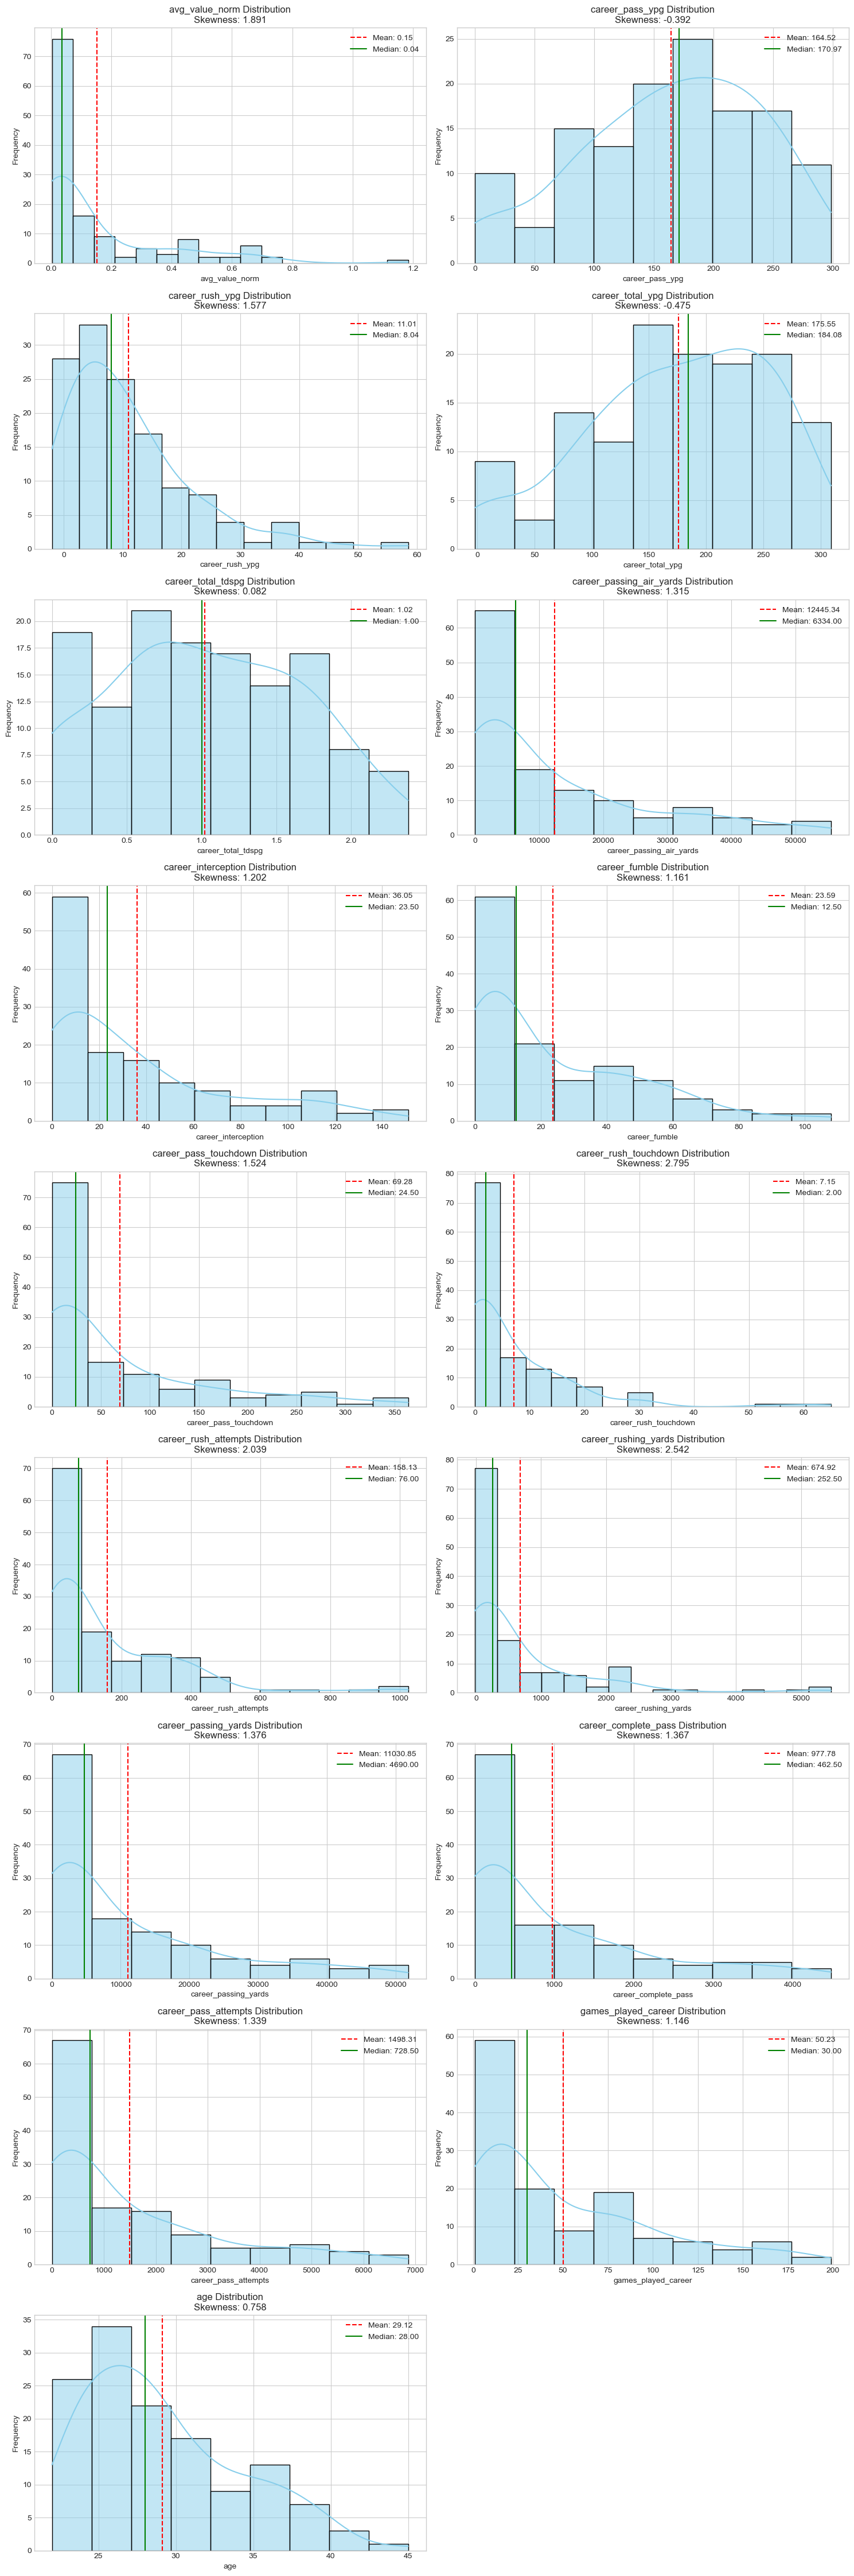

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import skew

# First, let's identify all numerical columns in the DataFrame
numeric_columns = qb_latest_contract_df.select_dtypes(include=['number']).columns

# Set up the figure size and style
plt.style.use('seaborn-v0_8-whitegrid')
fig_height = 5 * ((len(numeric_columns) + 1) // 2)  # Adjust height based on number of columns
plt.figure(figsize=(15, fig_height))

# Create histograms with KDE for each numerical column
for i, column in enumerate(numeric_columns, 1):
    plt.subplot((len(numeric_columns) + 1) // 2, 2, i)
    
    # Calculate skewness
    skewness = skew(qb_latest_contract_df[column].dropna())
    
    # Create histogram with KDE
    sns.histplot(qb_latest_contract_df[column].dropna(), kde=True, color='skyblue')
    
    # Add title and labels
    plt.title(f'{column} Distribution\nSkewness: {skewness:.3f}', fontsize=12)
    plt.xlabel(column)
    plt.ylabel('Frequency')
    
    # Add a vertical line for the mean
    plt.axvline(qb_latest_contract_df[column].mean(), color='red', linestyle='--', 
                label=f'Mean: {qb_latest_contract_df[column].mean():.2f}')
    
    # Add a vertical line for the median
    plt.axvline(qb_latest_contract_df[column].median(), color='green', linestyle='-', 
                label=f'Median: {qb_latest_contract_df[column].median():.2f}')
    
    plt.legend()

plt.tight_layout()
plt.show()

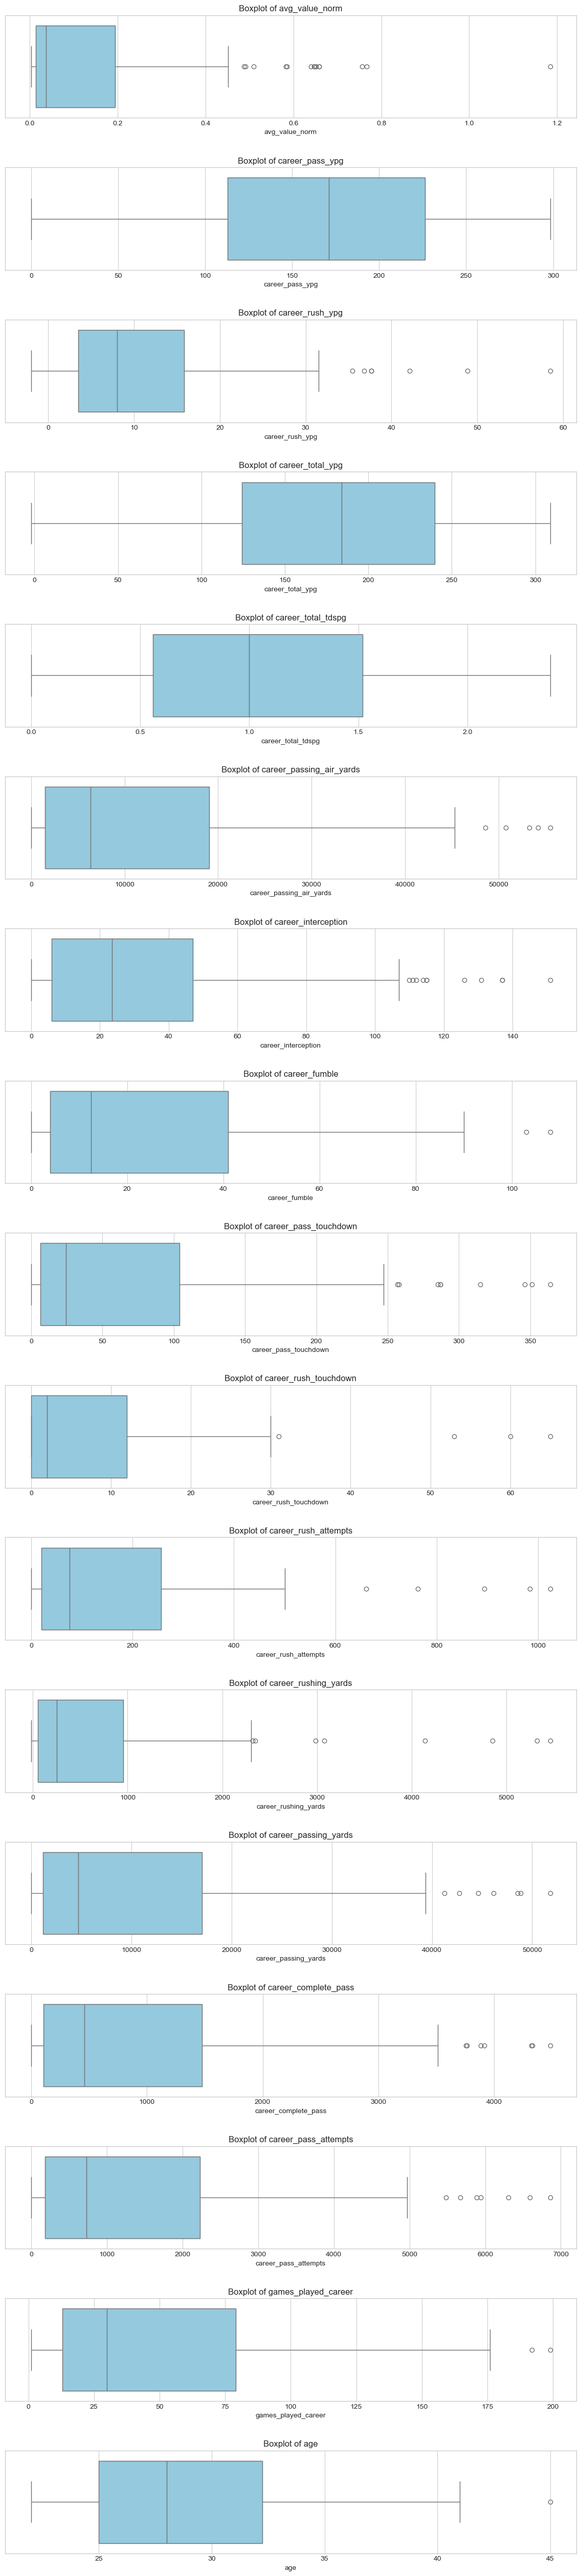

Created boxplots for 17 numeric columns: avg_value_norm, career_pass_ypg, career_rush_ypg, career_total_ypg, career_total_tdspg, career_passing_air_yards, career_interception, career_fumble, career_pass_touchdown, career_rush_touchdown, career_rush_attempts, career_rushing_yards, career_passing_yards, career_complete_pass, career_pass_attempts, games_played_career, age


In [21]:
# Select only numeric columns (continuous data)
numeric_columns = qb_latest_contract_df.select_dtypes(include=[np.number]).columns.tolist()

if len(numeric_columns) == 0:
    print("No numeric columns found in the DataFrame.")
else:
    # Set the figure size based on the number of columns
    plt.figure(figsize=(12, len(numeric_columns) * 3))
    
    # Create a boxplot for each numeric column
    for i, column in enumerate(numeric_columns, 1):
        plt.subplot(len(numeric_columns), 1, i)
        sns.boxplot(x=qb_latest_contract_df[column], color='skyblue')
        plt.title(f'Boxplot of {column}')
        plt.tight_layout()
    
    plt.tight_layout(pad=3.0)
    plt.show()
    
    # Print a summary of the numeric columns
    print(f"Created boxplots for {len(numeric_columns)} numeric columns: {', '.join(numeric_columns)}")

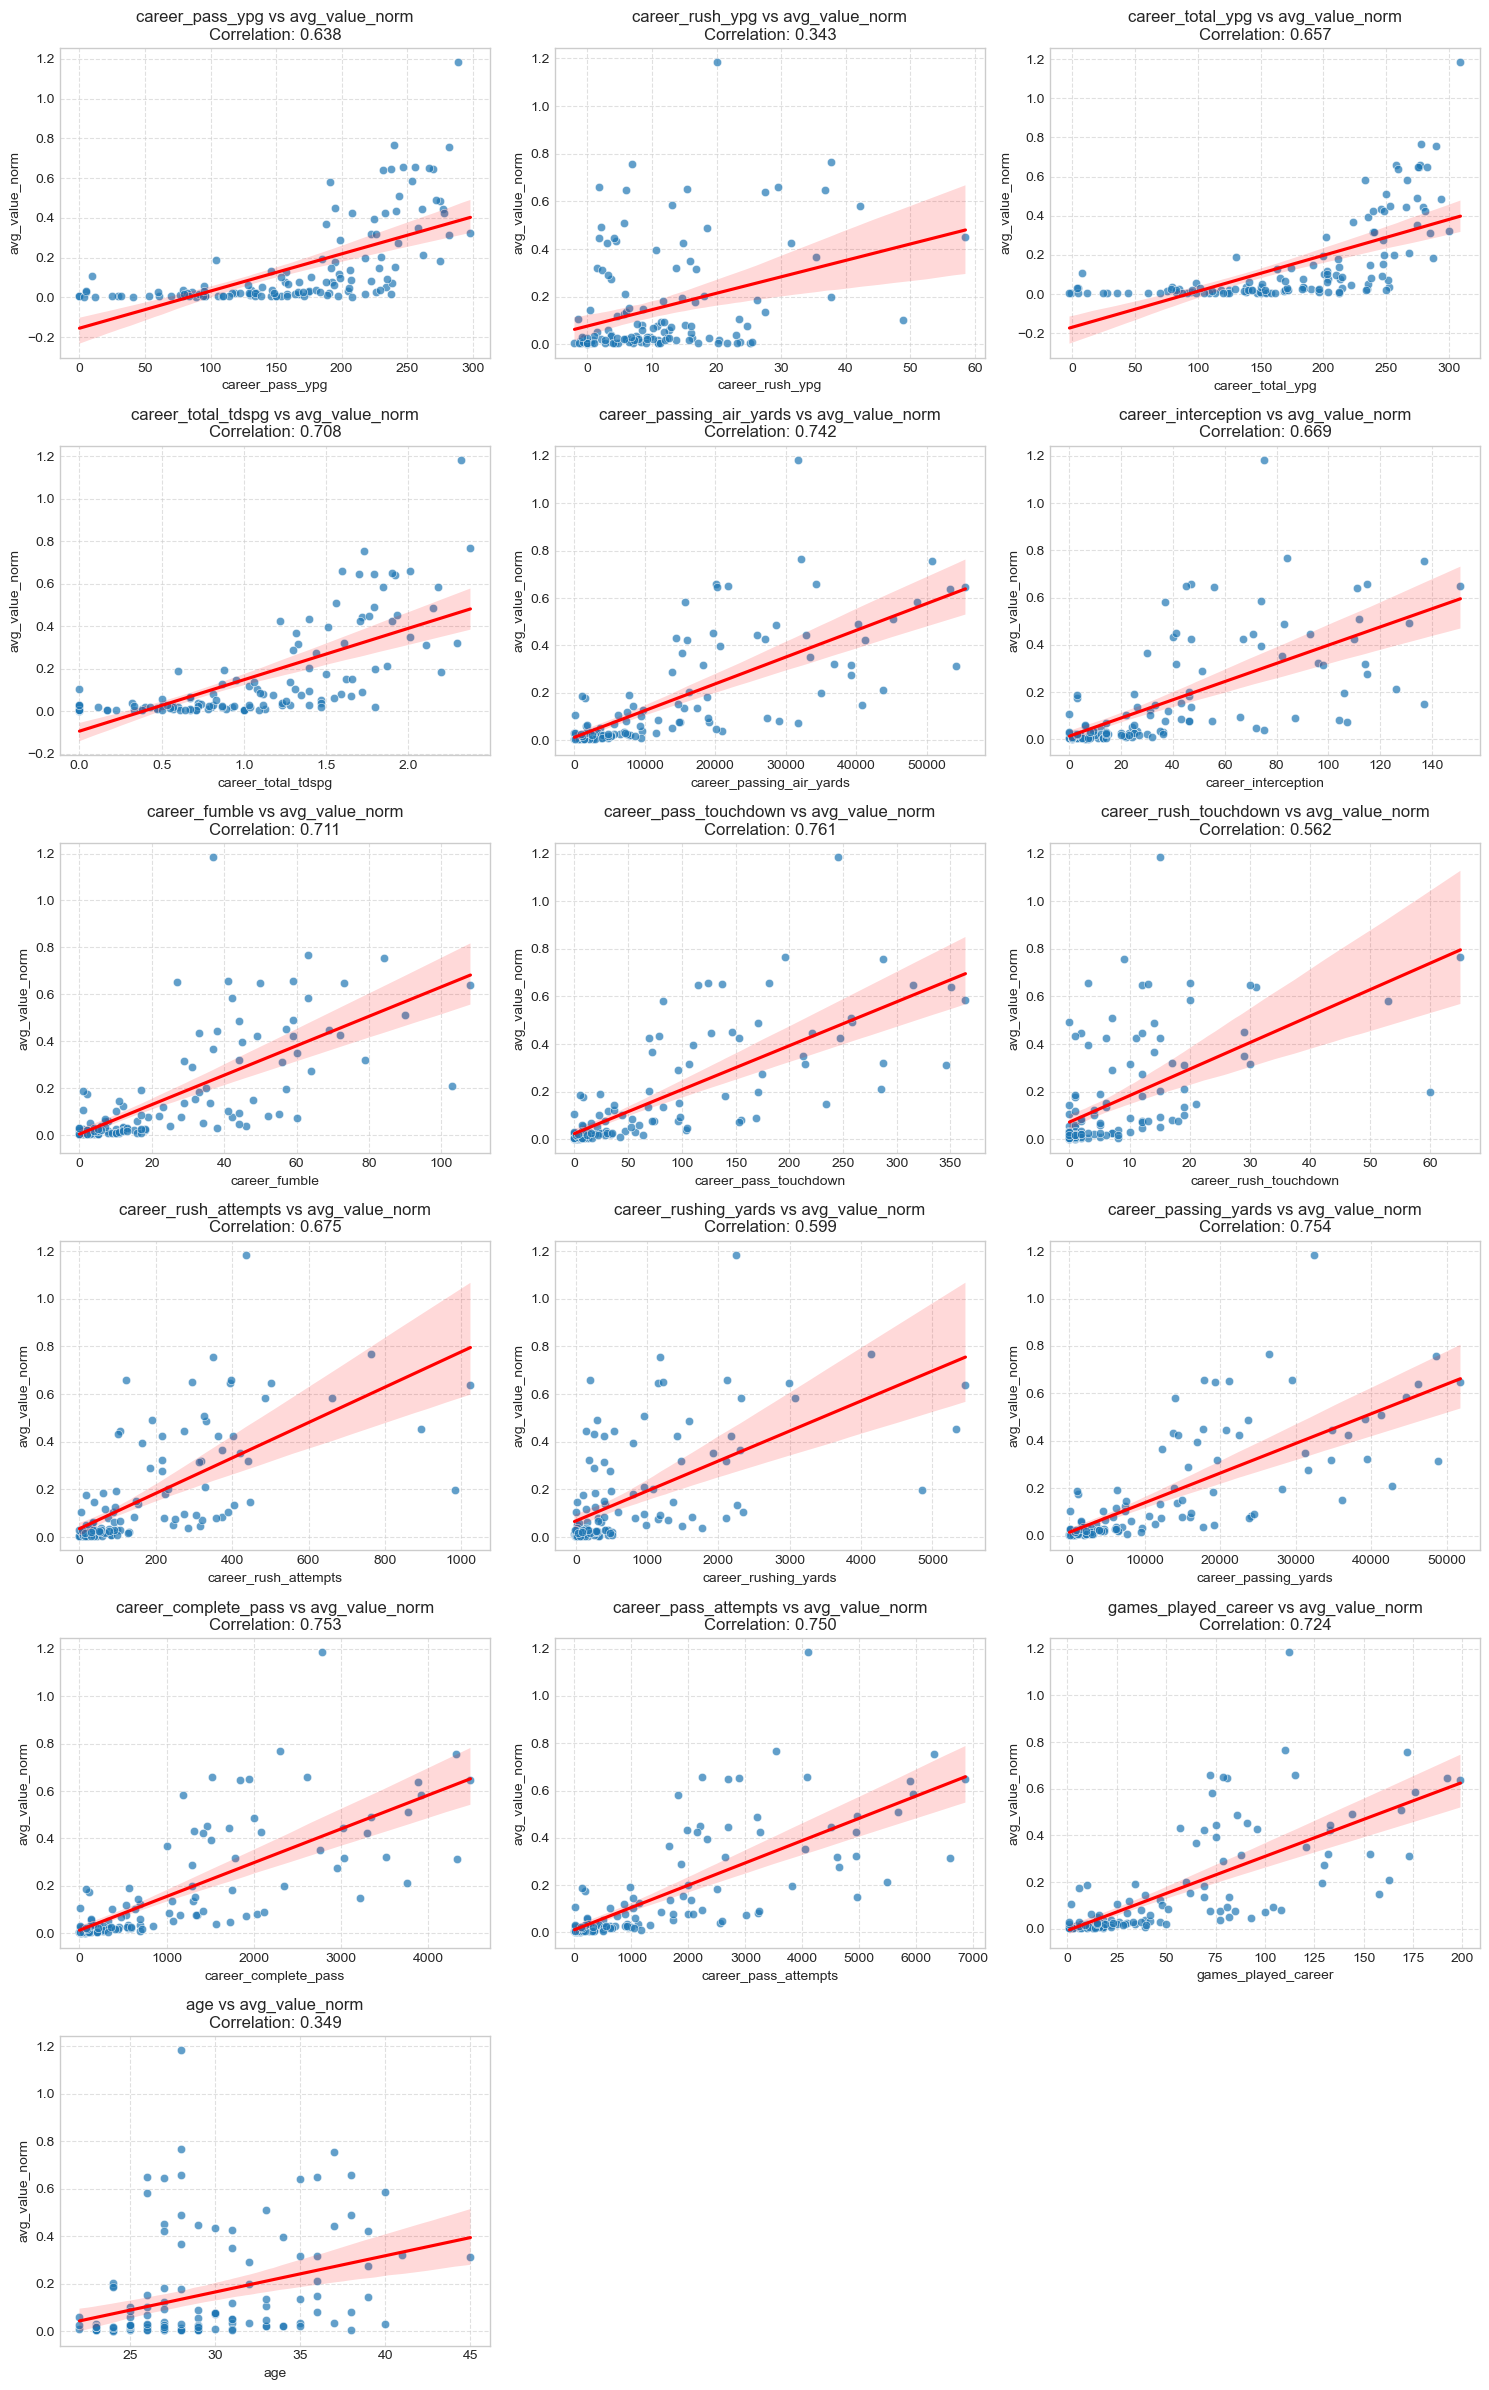

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from math import ceil

# Identify numeric columns (potential continuous variables)
# Excluding avg_value_norm as it's our target variable
numeric_cols = qb_latest_contract_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
if 'avg_value_norm' in numeric_cols:
    numeric_cols.remove('avg_value_norm')

# Set up the figure size and grid layout
n_plots = len(numeric_cols)
n_cols = 3  # Number of columns in the grid
n_rows = ceil(n_plots / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten()  # Flatten to make indexing easier

# Create scatterplots
for i, col in enumerate(numeric_cols):
    if i < len(axes):
        ax = axes[i]
        sns.scatterplot(
            data=qb_latest_contract_df,
            x=col,
            y='avg_value_norm',
            alpha=0.7,
            ax=ax
        )
        
        # Add regression line
        sns.regplot(
            data=qb_latest_contract_df,
            x=col,
            y='avg_value_norm',
            scatter=False,
            ax=ax,
            line_kws={'color': 'red'}
        )
        
        # Calculate correlation coefficient
        corr = qb_latest_contract_df[[col, 'avg_value_norm']].corr().iloc[0, 1]
        ax.set_title(f'{col} vs avg_value_norm\nCorrelation: {corr:.3f}')
        ax.set_xlabel(col)
        ax.set_ylabel('avg_value_norm')
        
        # Add grid for better readability
        ax.grid(True, linestyle='--', alpha=0.6)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

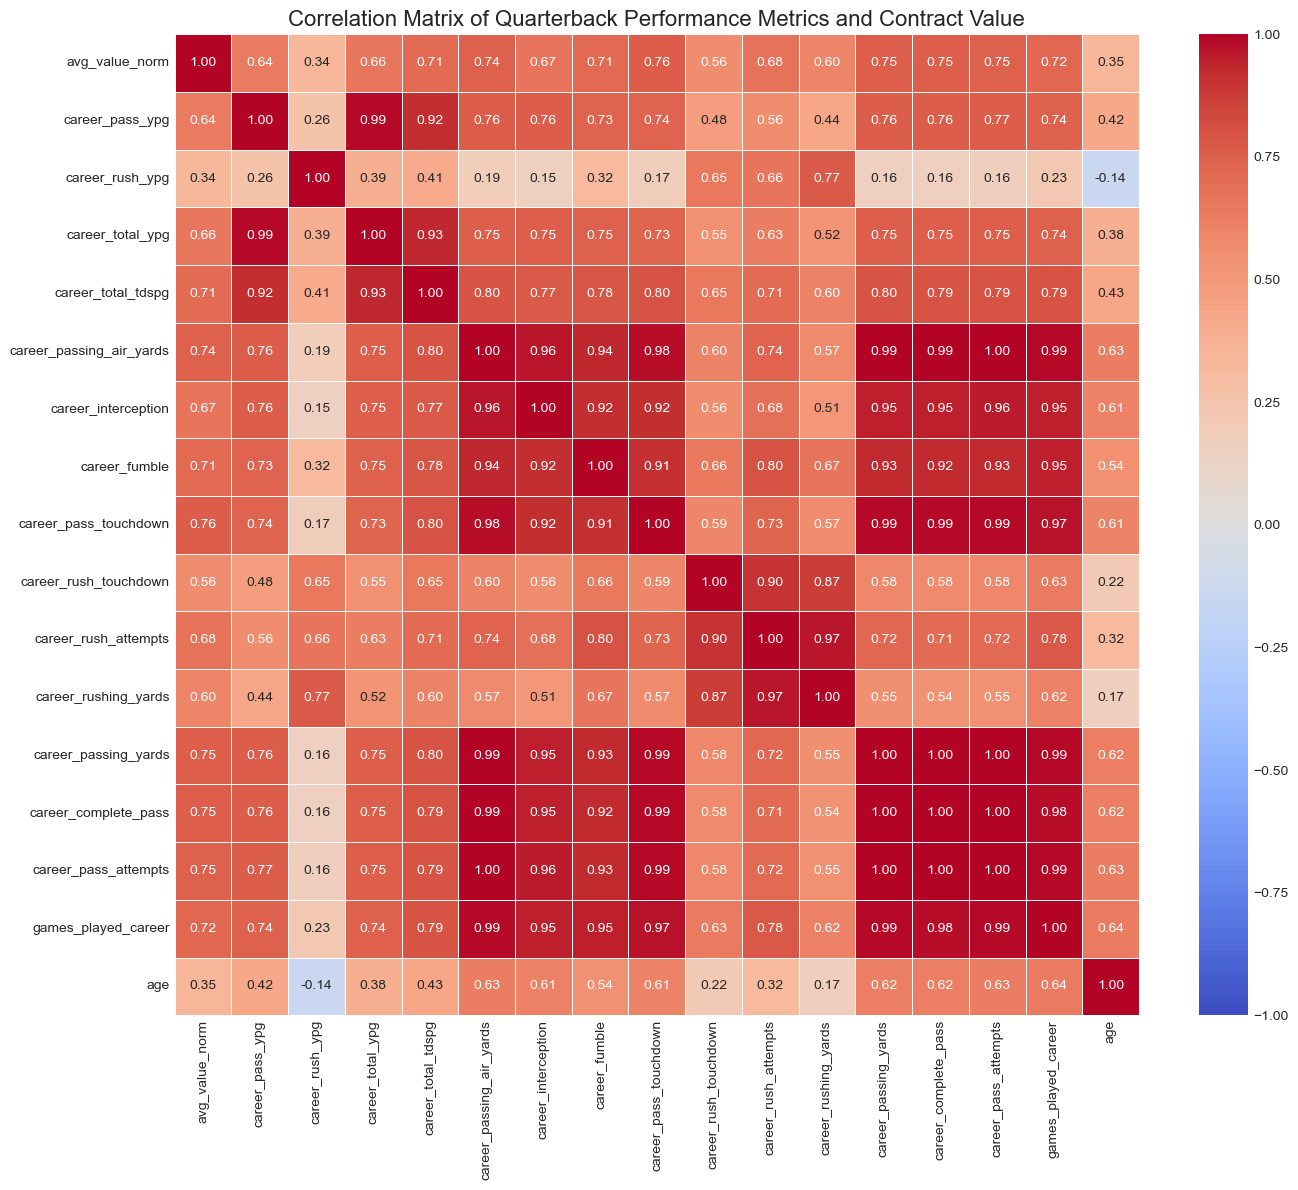

In [23]:
# Select the performance metrics and contract value columns
corr_columns = [
    'avg_value_norm','career_pass_ypg', 'career_rush_ypg',
    'career_total_ypg', 'career_total_tdspg', 'career_passing_air_yards',
    'career_interception', 'career_fumble', 'career_pass_touchdown',
    'career_rush_touchdown', 'career_rush_attempts', 'career_rushing_yards',
    'career_passing_yards', 'career_complete_pass', 'career_pass_attempts',
    'games_played_career', 'age'
]

# Calculate the correlation matrix
correlation_matrix = qb_latest_contract_df[corr_columns].corr()

# Create a heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, 
            annot=True,           # Show correlation values
            cmap='coolwarm',      # Color map
            fmt='.2f',            # Format for correlation values
            linewidths=0.5,       # Width of lines between cells
            vmin=-1, vmax=1)      # Range for correlation values

plt.title('Correlation Matrix of Quarterback Performance Metrics and Contract Value', fontsize=16)
plt.tight_layout()
plt.show()

/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWar

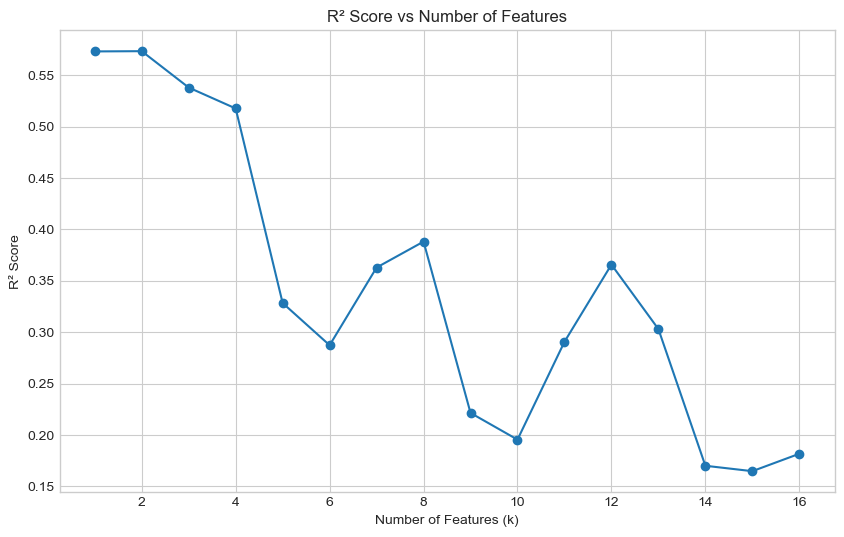

Optimal number of features: 2

Selected Features:
                 Feature       Score
0  career_pass_touchdown  133.822170
1   career_complete_pass  126.481237


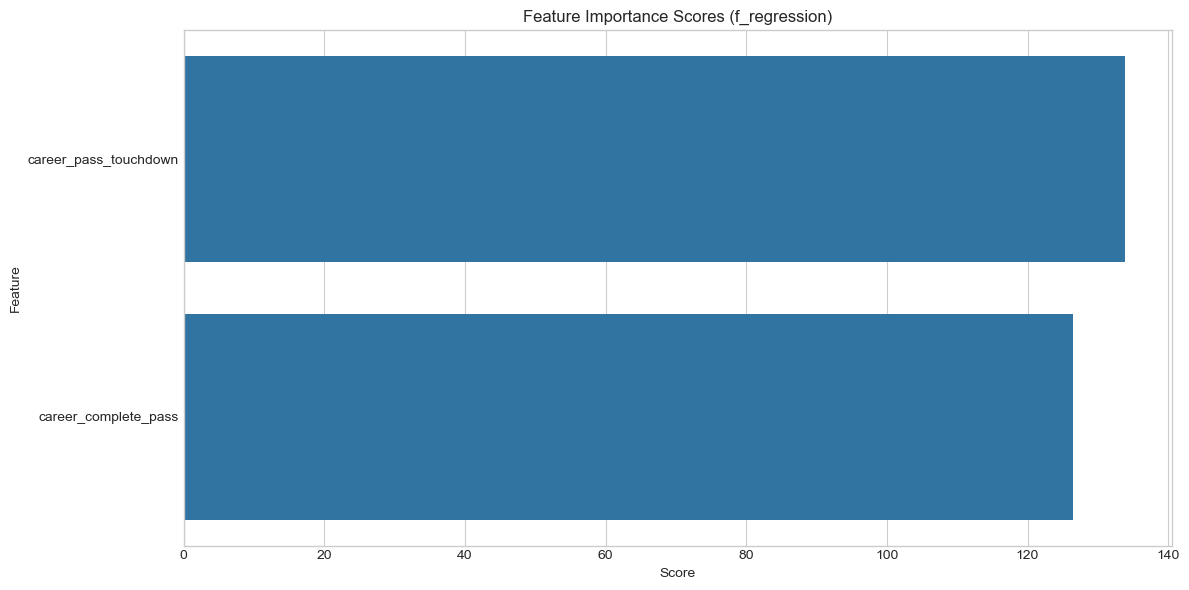


Model Performance with Selected Features:
Linear Regression:
  MSE: 0.0294
  RMSE: 0.1714
  R²: 0.5734
Ridge Regression:
  MSE: 0.0293
  RMSE: 0.1710
  R²: 0.5752
Random Forest:
  MSE: 0.0261
  RMSE: 0.1615
  R²: 0.6213


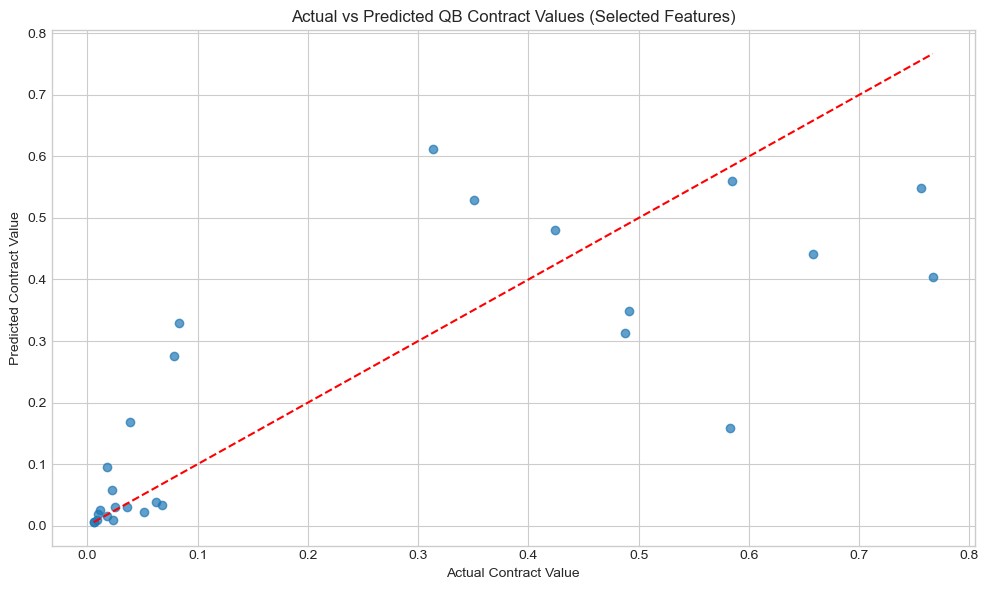


Selected Features (Mutual Information):
                Feature     Score
0  career_passing_yards  0.578018
1  career_pass_attempts  0.550312


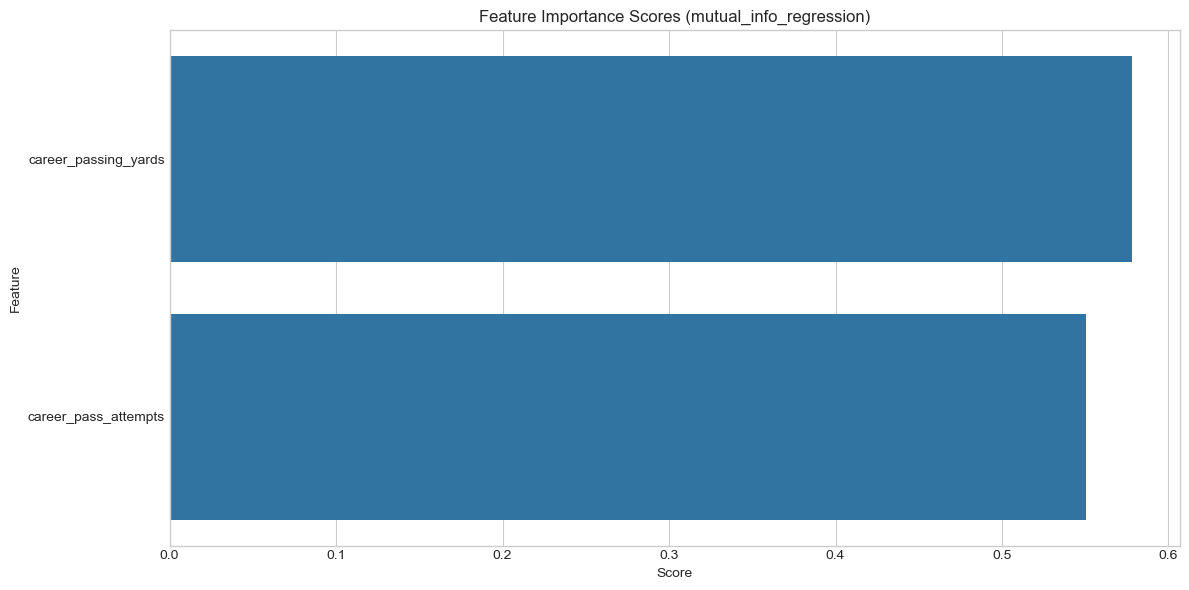


Comparison of Selected Features:
f_regression: ['career_pass_touchdown', 'career_complete_pass']
mutual_info_regression: ['career_passing_yards', 'career_pass_attempts']


In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression

# 1. Prepare the data
# Select numerical features for the model
features = ['career_pass_ypg', 'career_rush_ypg', 'career_total_ypg', 
            'career_total_tdspg', 'career_passing_air_yards', 'career_interception', 
            'career_fumble', 'career_pass_touchdown', 'career_rush_touchdown', 
            'career_rush_attempts', 'career_rushing_yards', 'career_passing_yards',
            'career_complete_pass', 'career_pass_attempts', 'games_played_career', 'age']

X = qb_latest_contract_df[features]
y = qb_latest_contract_df['avg_value_norm']

# 2. Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Apply SelectKBest with f_regression (linear correlation)
# We'll try different k values to find the optimal number of features
k_values = range(1, len(features) + 1)
r2_scores = []

for k in k_values:
    # Create feature selector
    selector = SelectKBest(f_regression, k=k)
    
    # Fit and transform the training data
    X_train_selected = selector.fit_transform(X_train, y_train)
    
    # Get selected feature indices
    selected_indices = selector.get_support(indices=True)
    
    # Transform test data
    X_test_selected = X_test.iloc[:, selected_indices]
    
    # Train a model with selected features
    model = LinearRegression()
    model.fit(X_train_selected, y_train)
    
    # Predict and evaluate
    y_pred = model.predict(X_test_selected)
    r2 = r2_score(y_test, y_pred)
    r2_scores.append(r2)

# Plot R² scores for different k values
plt.figure(figsize=(10, 6))
plt.plot(k_values, r2_scores, marker='o')
plt.xlabel('Number of Features (k)')
plt.ylabel('R² Score')
plt.title('R² Score vs Number of Features')
plt.grid(True)
plt.show()

# Find optimal k (number of features)
optimal_k = k_values[np.argmax(r2_scores)]
print(f"Optimal number of features: {optimal_k}")

# 4. Apply SelectKBest with optimal k
selector = SelectKBest(f_regression, k=optimal_k)
selector.fit(X_train, y_train)

# Get selected feature names and scores
selected_indices = selector.get_support(indices=True)
selected_features = [features[i] for i in selected_indices]
feature_scores = selector.scores_[selected_indices]

# Display selected features and their scores
feature_selection_df = pd.DataFrame({
    'Feature': selected_features,
    'Score': feature_scores
})
feature_selection_df = feature_selection_df.sort_values('Score', ascending=False)
print("\nSelected Features:")
print(feature_selection_df)

# Visualize feature scores
plt.figure(figsize=(12, 6))
sns.barplot(x='Score', y='Feature', data=feature_selection_df)
plt.title('Feature Importance Scores (f_regression)')
plt.tight_layout()
plt.show()

# 5. Build regression models with selected features
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

# Try different regression models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42)
}

# Compare models with selected features
print("\nModel Performance with Selected Features:")
for name, model in models.items():
    # Create pipeline with scaling
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])
    
    # Train model
    pipeline.fit(X_train_selected, y_train)
    
    # Predict and evaluate
    y_pred = pipeline.predict(X_test_selected)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    print(f"{name}:")
    print(f"  MSE: {mse:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  R²: {r2:.4f}")

# 6. Visualize actual vs predicted for best model
best_model = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))
])
best_model.fit(X_train_selected, y_train)
y_pred_best = best_model.predict(X_test_selected)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_best, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Contract Value')
plt.ylabel('Predicted Contract Value')
plt.title('Actual vs Predicted QB Contract Values (Selected Features)')
plt.tight_layout()
plt.show()

# 7. Alternative feature selection method: mutual_info_regression (captures non-linear relationships)
selector_mi = SelectKBest(mutual_info_regression, k=optimal_k)
selector_mi.fit(X_train, y_train)

# Get selected feature names and scores
selected_indices_mi = selector_mi.get_support(indices=True)
selected_features_mi = [features[i] for i in selected_indices_mi]
feature_scores_mi = selector_mi.scores_[selected_indices_mi]

# Display selected features and their scores
feature_selection_df_mi = pd.DataFrame({
    'Feature': selected_features_mi,
    'Score': feature_scores_mi
})
feature_selection_df_mi = feature_selection_df_mi.sort_values('Score', ascending=False)
print("\nSelected Features (Mutual Information):")
print(feature_selection_df_mi)

# Visualize feature scores
plt.figure(figsize=(12, 6))
sns.barplot(x='Score', y='Feature', data=feature_selection_df_mi)
plt.title('Feature Importance Scores (mutual_info_regression)')
plt.tight_layout()
plt.show()

# 8. Compare selected features from both methods
print("\nComparison of Selected Features:")
print(f"f_regression: {selected_features}")
print(f"mutual_info_regression: {selected_features_mi}")

Yes, there are several ways to improve this code:

1. **Error handling**: Add try-except blocks to handle potential errors during model fitting or evaluation.

2. **Code organization**: Consider refactoring into functions for better modularity and reusability (e.g., separate functions for model evaluation, visualization, and feature selection).

3. **Hyperparameter tuning**: Implement cross-validation with GridSearchCV or RandomizedSearchCV to optimize model parameters rather than using fixed values.

4. **Model persistence**: Add code to save the best model using joblib or pickle for future use.

5. **Visualization enhancements**:
   - Add confidence intervals to predictions
   - Include residual plots to better understand model errors
   - Use log scale if data is skewed

6. **Feature engineering**: Consider adding interaction terms or polynomial features to capture more complex relationships.

7. **Evaluation metrics**: Include additional metrics like MAE (Mean Absolute Error) which is less sensitive to outliers.

8. **Documentation**: Add more comments explaining the rationale behind parameter choices and interpretation of results.

9. **Performance optimization**: For large datasets, consider using more efficient implementations or parallel processing.

10. **Cross-validation**: Implement k-fold cross-validation for more robust performance estimation instead of a single train-test split.

Residual Analysis:
Mean of residuals: 0.0153
Standard deviation of residuals: 0.1608


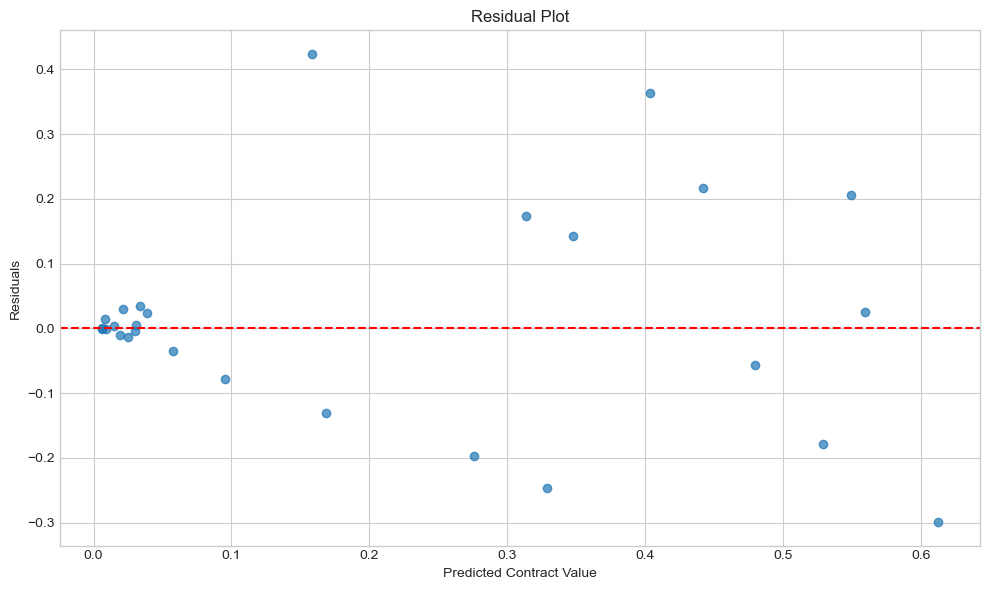

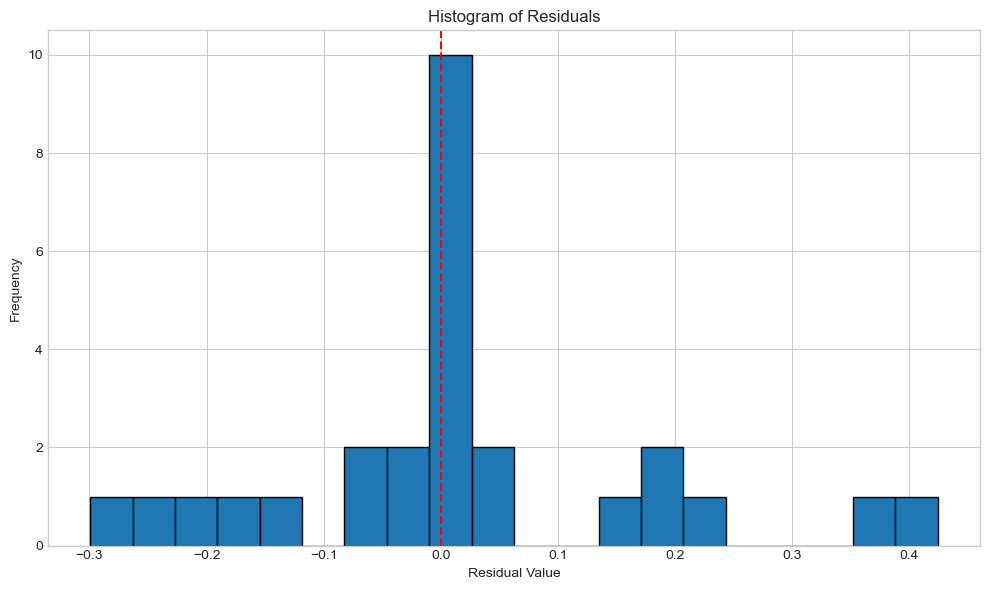

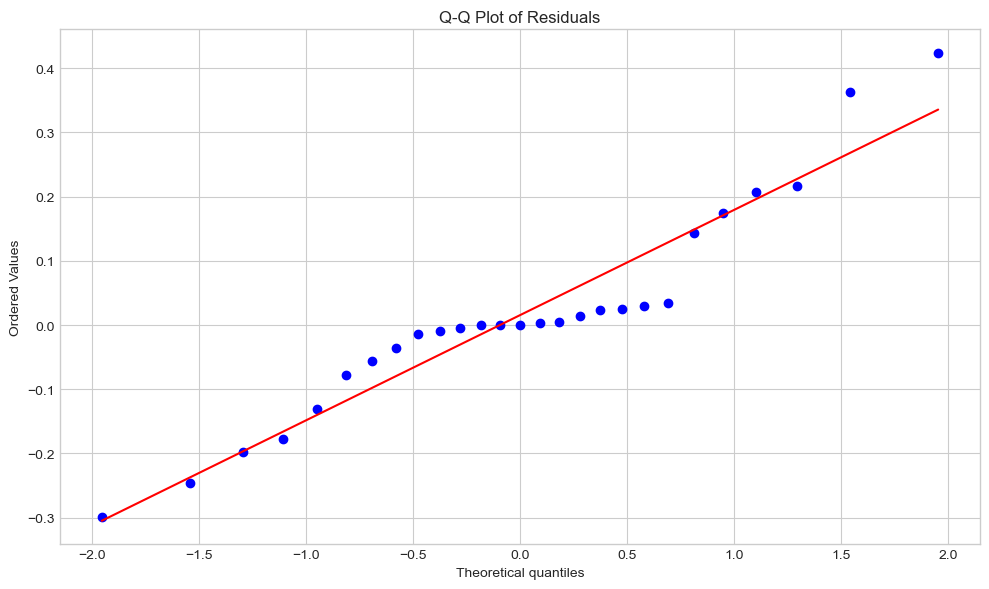

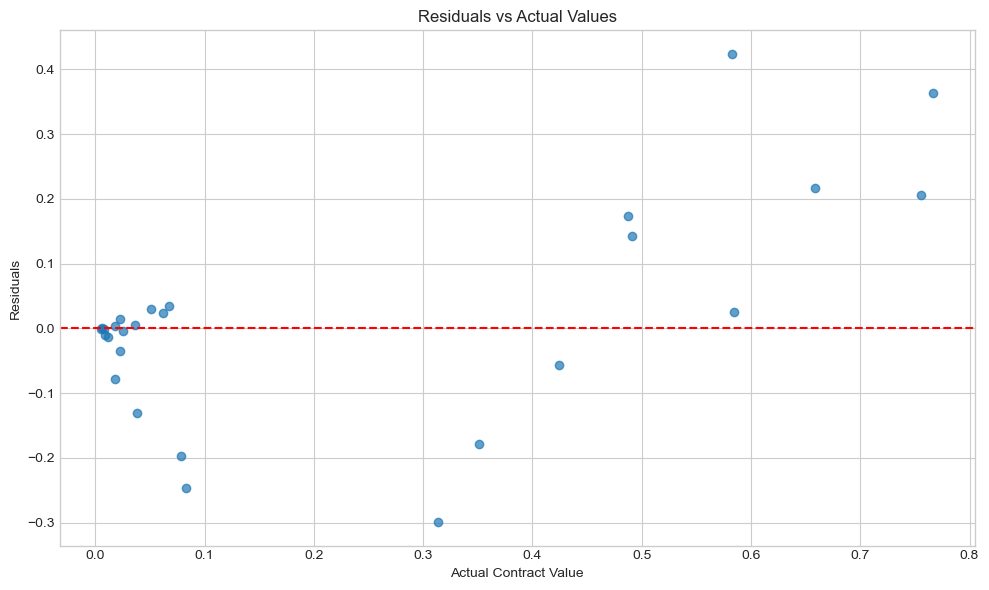

Residual Statistics:
Mean: 0.015323
Median: 0.000114
Standard Deviation: 0.160751


In [25]:
# Calculate residuals
residuals = y_test - y_pred_best

# 1. Basic residual statistics
print("Residual Analysis:")
print(f"Mean of residuals: {np.mean(residuals):.4f}")
print(f"Standard deviation of residuals: {np.std(residuals):.4f}")

# 2. Residual plot (predicted vs residuals)
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_best, residuals, alpha=0.7)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Contract Value')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.tight_layout()
plt.show()

# 3. Histogram of residuals
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=20, edgecolor='black')
plt.axvline(x=0, color='r', linestyle='--')
plt.xlabel('Residual Value')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.tight_layout()
plt.show()

# 4. Q-Q plot to check normality of residuals
import scipy.stats as stats
plt.figure(figsize=(10, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.tight_layout()
plt.show()

# 5. Check for heteroscedasticity
plt.figure(figsize=(10, 6))
plt.scatter(y_test, residuals, alpha=0.7)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Actual Contract Value')
plt.ylabel('Residuals')
plt.title('Residuals vs Actual Values')
plt.tight_layout()
plt.show()

# Calculate basic statistics of residuals
residual_mean = np.mean(residuals)
residual_median = np.median(residuals)
residual_std = np.std(residuals)

# Print the statistics
print("Residual Statistics:")
print(f"Mean: {residual_mean:.6f}")
print(f"Median: {residual_median:.6f}")
print(f"Standard Deviation: {residual_std:.6f}")


This analysis will help you evaluate your model's performance by:
1. Calculating basic statistics of residuals (should be close to zero)
2. Creating a residual plot to check for patterns (ideally random around zero)
3. Generating a histogram to visualize residual distribution (ideally normal)
4. Producing a Q-Q plot to assess normality of residuals
5. Checking for heteroscedasticity (non-constant variance)

These visualizations will help identify potential issues with your model and guide further improvements.

The mean and median of residuals should ideally be close to zero for an unbiased model. The standard deviation gives us an idea of the spread of the residuals. If these values are significantly different from zero, it might indicate issues with the model's fit.